<div class='bar_title'></div>

*Enterprise AI*

# Tutorial 4 - Model Deployment with ZenML

Gunther Gust / Viet Nguyen<br>
Chair of Enterprise AI

Summer Semester 25

<img src="https://github.com/GuntherGust/tds2_data/blob/main/images/d3.png?raw=true" style="width:20%; float:left;" />

In machine learning, building a model and evaluating its performance on your local machine is just the first step in the broader machine learning pipeline, often referred to as prototyping. In real-world applications, most of the effort actually goes into preparing data, ensuring reproducibility, tracking experiments, and deploying models so they can deliver value in a business context. This is where MLOps comes in - a set of best practices and tools designed to automate and manage the machine learning lifecycle, from data ingestion to deployment and monitoring in production.

[ZenML](https://docs.zenml.io/) is an extensible, open-source MLOps framework which is built for creating reproducible, production-ready ML pipelines. It integrates with tools you already know (like scikit-learn, TensorFlow, PyTorch) and brings a structured way to go from experimentation to production. 

<div style="text-align: center;">
  <img src="https://cdn.prod.website-files.com/65264f6bf54e751c3a776db1/652fbc27eaacc8b0ccf86a81_ci-cd-for-ml-systems.gif" alt="ZenMLPipeline" width="700"/>
</div>

In traditional software development, **Continuous Integration and Continuous Deployment (CI/CD)** helps automate the process of testing code and safely releasing updates. Think about machine learning model as a special type of software, where its CI/CD is more complex. The process involves automating the validation of data and models, not just code. Since ML models depend heavily on ever-changing data, ML systems also require **Continuous Training (CT)** to keep models up to date and performing well.

That said, we will focus on the offline stages: data pre-processing, training, and evaluation. You can read more about deployment and automation [here](https://www.zenml.io/blog/all-continuous-all-the-time-pipeline-deployment-patterns-with-zenml).

In this tutorial, you will:

- Build a ML pipeline with ZenML (data -> model -> evaluation)
- Track experiments
- Explore the Dashboard

### 1. Installing ZenML

If you're setting up the environment locally, you'll need to run the following command to install the necessary package:
```python
!pip install "zenml[templates,server]" notebook
```
However, if you're using GitHub Codespaces, everything is already set up for you. When you open the Codespace for this repository, a pre-configured, Docker-based development environment is automatically created. This setup is defined by the `.devcontainer/devcontainer.json` file, which tells GitHub how to configure your Python environment. Let’s break down what this file does:

#### 1.1. Base Image:
```json
"image": "mcr.microsoft.com/devcontainers/python:0-3.10"
```
- This uses an official Microsoft-provided Docker image with `Python 3.10` already installed.
- It's a clean and consistent environment, regardless of your local setup.

#### 1.2. Post Creation Command:
We first all instasll `zenml` dependencies:
```json
"postCreateCommand": "pip3 install zenml[templates,server] notebook && zenml integration install sklearn -y && pip3 install -r requirements.txt"
```
- Once the container is built, this command runs automatically.
- It first installs the dependencies of `zenml` with the integration of `scikit-learn`.
- Then, it installs all Python libraries listed in the `requirements.txt` file. 

When a container is created, a virtualized Python environment is ready to use. With this setup, you don't need to install any package manually necessary to run this notebook. Everything is automated via Docker and Github Codespaces. Simply open the Codespace, and your dev environment is fully prepared.

### 2. Programming with ZenML

Let's start by initializing a ZenML project:

In [10]:
!zenml init

/home/vscode/.local/lib/python3.10/site-packages/zenml/cli/utils.py:43: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Found existing ZenML repository at path 
'/workspaces/eai_ss25_tutorial_04_zenml'.
⠋ Initializing ZenML repository at /workspaces/eai_ss25_tutorial_04_zenml.
⠋ Initializing ZenML repository at /workspaces/eai_ss25_tutorial_04_zenml.



### 2.1. Data Loading

We'll use the **Iris dataset**, which contains measurements of 150 flowers from 3 species: Setosa, Versicolor, Virginica

<div style="display: flex; justify-content: space-around; align-items: center;">
  <div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="120"/><br>
    <b>Iris Setosa</b>
  </div>
  <div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="180"/><br>
    <b>Iris Versicolor</b>
  </div>
  <div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width="180"/><br>
    <b>Iris Virginica</b>
  </div>
</div>

In [11]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris(as_frame=True)
df = iris.frame
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Let's visualize the data:

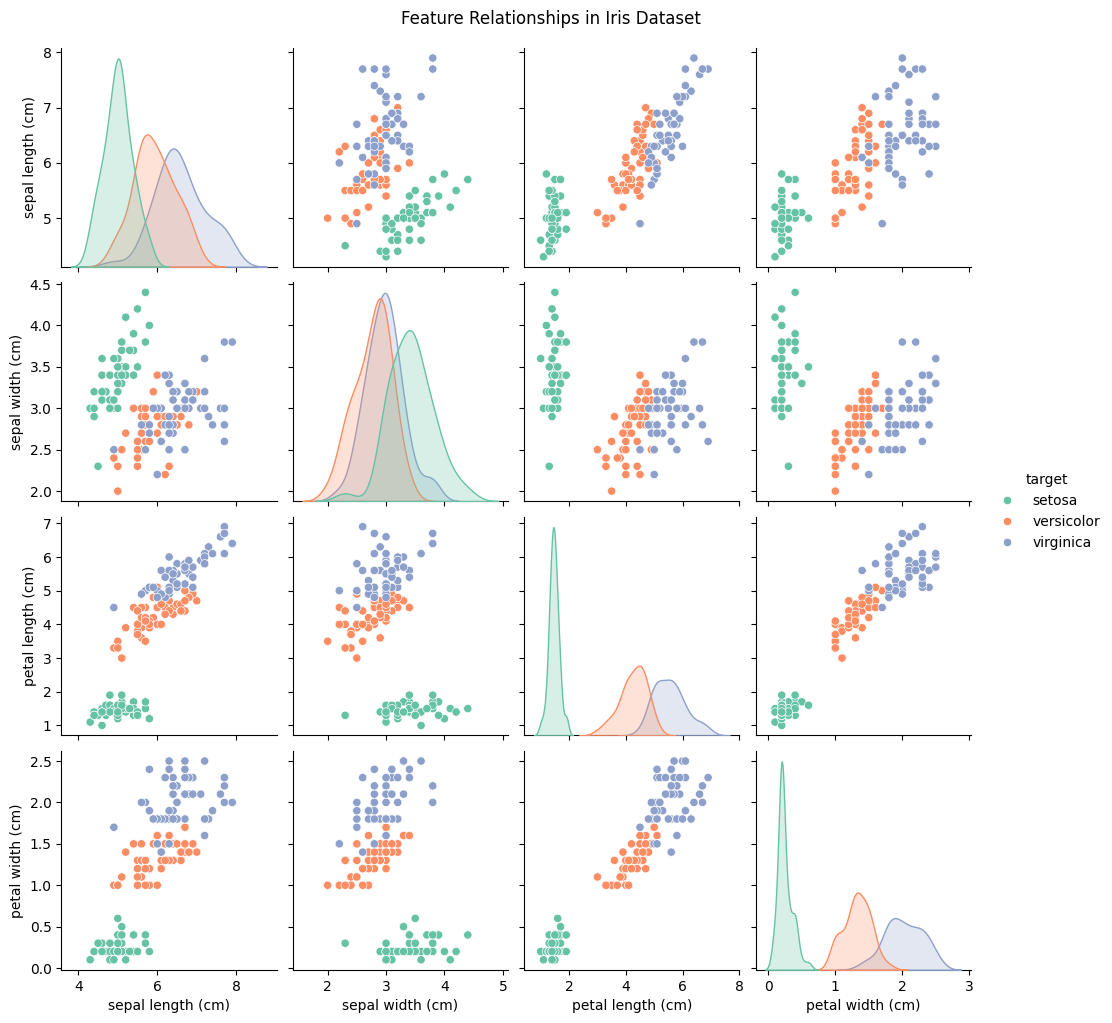

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# get species' names
vis_df = df.copy()
vis_df['target'] = df['target'].map({i: name for i, name in enumerate(iris.target_names)})
sns.pairplot(vis_df, hue="target", palette='Set2')
plt.suptitle("Feature Relationships in Iris Dataset", y=1.02)
plt.show()

Each sample has the following features:
- Sepal length 
- Sepal width
- Petal length
- Petal width

Our goal is to predict the flower species based on these features. 

Before using ZenML, we need to initialize a ZenML repository:

### 2.2. Defining steps
A ZenML **step** is a single, modular unit of work that performs one logical task. For example, a task can be loading data or training a model. Steps are just Python functions decorated with `@step` to make them resusable and easy to connect. Think of it as building blocks of your ML workflow.

Let's create a step that loads the dataset:

In [13]:
from zenml.steps import step
from typing_extensions import Annotated

@step 
def load_data() -> Annotated[pd.DataFrame, "data_loader"]:
    iris = load_iris(as_frame=True)
    return iris.frame

Unlike some other programming languages like Java, C, or C++, Python does not require you to declare *data type* of a variable. Instead, it is dynamically typed, which means that variables can change type at runtime. While this makes Python easy to start with, it can also lead to bugs that are hard to catch, especially in larger projects. That's why Python supports *optional type hints*, which help tools and developers understand what kind of data is expected. Here, the `Annotated` class from `typing_extensions` allows you to add extra information to these hints. ZenML uses this to tag inputs and outputs with metadata for the artifacts, which you will see later. 

For example, in the function `load_data`, the `-> Annotated[pd.DataFrame, "data_loader"`  syntax tells ZenML that this step returns a `pandas DataFrame`, and provides additional metadata using the `Annotated` wrapper. Specifically, the `data_loader` serves as a name tag for the output [artifact](https://docs.zenml.io/concepts/artifacts). ZenML automatically stores the inputs and outputs of each step as artifacts, which makes it easy to track, reuse, and retrieve results for reproducibility, debugging, or monitoring.

Next, we can put the logic of splitting data into training and test sets into another step: 

In [14]:
from sklearn.model_selection import train_test_split
from typing import Tuple
@step
def split_data(df: pd.DataFrame) -> Tuple[
    Annotated[pd.DataFrame,"X_train"],
    Annotated[pd.DataFrame,"X_test"],
    Annotated[pd.Series,"y_train"],
    Annotated[pd.Series,"y_test"]]:
    X = df.drop("target", axis=1)
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

You can also put the scaling and encoding steps into separate steps (assignment 2). After preprocessing and preparing data, training model logic can be defined as ist own step:

In [15]:
from sklearn.ensemble import RandomForestClassifier

@step 
def train_model(X_train, y_train) -> Annotated[RandomForestClassifier, "model"]:
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

Once trained, we want to measure how well the model performs. This step predicts on test data and prints a accuracy report on the test set:

In [16]:
@step
def evaluate_model(model: RandomForestClassifier, X_test, y_test) -> Annotated[float, "accuracy"]:
    score = model.score(X_test, y_test)
    return score

### 2.3. Definining a pipeline

A ZenML **pipeline** connects multiple steps into a full workflow. It specifies the order in which steps run and how data flows between them, making the process reproducible and easy to run end-to-end. Think of it as a recipe for your ML project.

Our pipeline merge all of the above defined steps:
1. loading the data
2. splitting the data into sets
3. training the model
4. evaluating the model

The pipeline function is defined with decorator `@pipeline`:

In [17]:
from zenml.pipelines import pipeline

@pipeline
def iris_pipeline():
    df = load_data()
    X_train, X_test, y_train, y_test = split_data(df)
    model = train_model(X_train, y_train)
    score = evaluate_model(model, X_test, y_test)

### 2.4. Running the Pipeline

Now that everything is connected, running the pipeline executes all steps in order. ZenML handles passing data between steps and caches results to save time:

In [18]:
iris_pipeline()

Initiating a new run for the pipeline: iris_pipeline.


/home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/integration.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In a future release, the default Python package installer used by ZenML to build container images for your containerized pipelines will change from 'pip' to 'uv'. To maintain current behavior, you can explicitly set python_package_installer=PythonPackageInstaller.PIP in your DockerSettings.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_data has started.
[load_data] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.
Step load_data has finished in 0.220s.
Step split_data has started.
[split_data] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can 

[split_data] /home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)


Step split_data has finished in 0.482s.
Step train_model has started.
[train_model] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.
[train_model] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.
Step train_model has finished in 0.151s.


[train_model] /home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)
[train_model] /home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)


Step evaluate_model has started.
[evaluate_model] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.
[evaluate_model] By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.


[evaluate_model] /home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)
[evaluate_model] /home/vscode/.local/lib/python3.10/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)


Step evaluate_model has finished in 0.373s.
Pipeline run has finished in 2.793s.


PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2025, 5, 29, 18, 29, 27, 949203), updated=datetime.datetime(2025, 5, 29, 18, 29, 30, 795223), user_id=UUID('4a7946c3-7fa4-4eb1-b618-08266bc44e16'), project_id=UUID('b90b9681-514c-4bcb-8f22-673a186ae8b9'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2025, 5, 29, 16, 54, 15, 527315), updated=datetime.datetime(2025, 5, 29, 16, 54, 15, 527333), user_id=None), metadata=None, resources=None, id=UUID('99237cc3-3dc2-41de-8d6c-44c6626ff133'), permission_denied=False, name='default'), pipeline=PipelineResponse(body=PipelineResponseBody(created=datetime.datetime(2025, 5, 29, 18, 1, 51, 107405), updated=datetime.datetime(2025, 5, 29, 18, 1, 51, 107424), user_id=UUID('4a7946c3-7fa4-4eb1-b618-08266bc44e16'), project_id=UUID('b90b9681-514c-4bcb-8f22-673a186ae8b9')), metadata=None, resources=None, id=UUID('17b5b6dc-6fba-4d24-b29e-171cc5f0e59c'), permissio

### 2.5. Loading the artifacts

One of the great things about using ZenML is that it automatically stores all the inputs and outputs (artifacts) from each step of your pipeline. These artifacts can include your trained models, accuracy scores, datasets, and more. 

An artifact is basically the saved result from one of the ZenML pipeline steps. For example:
- The trained model from `train_model` step is an artifact
- The accuracy from `evaluate_model` is also an artifact

ZenML stores these so you can use them later without re-reunning the pipeline.

#### Why are they important?
Artifacts are essential in real-world machine learning because they act as saved outputs of each pipeline step like models, accuracy scores, or datasets. For example, if training crashes or a model underperforms in production, you can reload previous artifacts to resume work, debug, or roll back to a stable version. They also support comparison between model versions, monitoring for performance drift, and tracking exactly what was used to make a prediction, which makes your workflow more reliable, reproducible, and auditable.

For example, we can import the ZenML client and retrieve the accuracy artifact by its name:

In [21]:
from zenml.client import Client

# connect to ZenML client
client = Client()

# retrieve accuracy artifact, with the name tag above
acc_artifact = client.get_artifact_version("accuracy")

# print out the actual value
acc = acc_artifact.load()
print("Test accuracy from previous run: ", acc)

Test accuracy from previous run:  1.0


### 2.6. ZenML DashBoard

The final feature of ZenML we want to explore in this assignment is the Dashboard. ZenML’s dashboard provides an intuitive, out-of-the-box visualization of your pipelines and the artifacts generated during each run. This means you can easily track and inspect all the outputs, intermediate data, and models produced throughout your pipeline executions. 

To launch the dashboard, simply run `!zenml up`. Once started, you can navigate through your pipeline’s structure and examine all associated artifacts without any extra setup. You can just enter arbitrary information until seeing the Dashboard button. Since this is just a local server, the input information will not be stored anyway.

In [22]:
!zenml up

/home/vscode/.local/lib/python3.10/site-packages/zenml/cli/utils.py:43: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
The `zenml up` command is deprecated and will be removed in a future release. 
Please use the `zenml login --local` command instead.
Calling `zenml login --local`...
Deploying a local daemon ZenML server.
⠋ Starting service 'DaemonZenServer[519545a6-285f-4a4b-9cb1-563d67128aea] (type:
zen_server, flavor: daemon)'.
⠙ Starting service 'DaemonZenServer[519545a6-285f-4a4b-9cb1-563d67128aea] (type:
zen_server, flavor: daemon)'.
⠹ Starting service 'DaemonZenServer[519545a6-285f-4a4b-9cb1-563d67128aea] (type:
zen_server, flavor: daemon)'.
⠸ Starting service 'DaemonZenServer[519545a6-285f-4a4b-9cb1-563d67128aea] (type:
zen_server, flavor: daemon)'.
⠼ Starting ser

### Conclusion

In this tutorial, we explored how to use ZenML to structure a simple ML workflow using the Iris dataset. We learned how to define steps for loading data, splitting it, training a model, and evaluating it. Each step automatically stores its output as a versioned artifact. These artifacts make your pipeline reproducible, traceable, and easy to monitor and debug.

While we didn’t cover deployment in this tutorial, ZenML offers many powerful features you can explore, such as:
- Model deployment to cloud services
- Experment tracking and visual dashboards
- Automated retraininig pipelines
- Online monitoring
- Integration with tools like MLFlow and Weight & Biases (very cool for large projects, including thesis)

You can check out more features and guides on their [official website](https://www.zenml.io/). Have fun experimenting and building your own pipelines! 